# Sample Based Interior/Edge Segmentation for 2D Data

---

Classifies each pixel as either Cell Edge, Cell Interior, or Background.

There are 2 different Cell Edge classes (Cell-Cell Boundary and Cell-Background Boundary)

In [1]:
import os
import errno

import numpy as np

import deepcell
from deepcell.utils.data_utils import get_data
from tensorflow.keras.utils import get_file

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [2]:
def load_data(path, mode, test_size=0.2, seed=0):
    """Loads dataset.
    Args:
         test_size (float): fraction of data to reserve as test data
        seed (int): the seed for randomly shuffling the dataset
    Returns:
           tuple: (x_train, y_train), (x_test, y_test).
    """
    basepath = os.path.expanduser(os.path.join('~', '.keras', 'datasets'))
    prefix = path.split(os.path.sep)[:-1]
    data_dir = os.path.join(basepath, *prefix) if prefix else basepath
    if not os.path.exists(data_dir):
        os.makedirs(data_dir)
    elif not os.path.isdir(data_dir):
        raise IOError('{} exists but is not a directory'.format(data_dir))

    train_dict, test_dict = get_data(
        path,
        mode=mode,
        test_size=test_size,
        seed=seed)
    x_train, y_train = train_dict['X'], train_dict['y']
    x_test, y_test = test_dict['X'], test_dict['y']
    return (x_train, y_train), (x_test, y_test)

## Load the data

### Download the data from `deepcell.datasets`

`deepcell.datasets` provides access to a set of annotated live-cell imaging datasets which can be used for training cell segmentation and tracking models.
All dataset objects share the `load_data()` method, which allows the user to specify the name of the file (`path`), the fraction of data reserved for testing (`test_size`) and a `seed` which is used to generate the random train-test split.
Metadata associated with the dataset can be accessed through the `metadata` attribute.

In [21]:
# Have to stack the batches together

file = np.load('../train.npz')

In [22]:
file['X'].shape

(440, 100, 530, 530, 1)

In [29]:
X = np.vstack(file['X'])

In [30]:
X = X[0:-1:440]

In [31]:
print(X.shape)

(100, 530, 530, 1)


In [32]:
y = np.vstack(file['y'])[0:-1:440]
print(y.shape)

(100, 530, 530, 1)


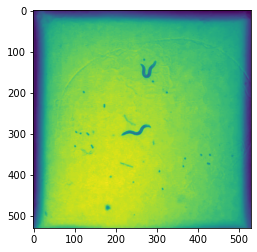

In [38]:
import matplotlib.pyplot as plt
plt.imshow(X[99])

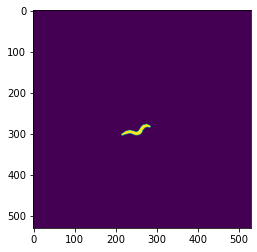

In [39]:
plt.imshow(y[99])

In [40]:
# Save it as seg_train.npz

np.savez("../seg_train.npz", X=X, y=y)

In [3]:
# Download the data (saves to ~/.keras/datasets)
filename = '../seg_train.npz'
test_size = 0.1 # % of data saved as test
seed = 0 # seed for random train-test split

(X_train, y_train), (X_test, y_test) = load_data(filename, mode='sample',test_size=test_size, seed=seed)

print('X.shape: {}\ny.shape: {}'.format(X_train.shape, y_train.shape))

X.shape: (90, 530, 530, 1)
y.shape: (90, 530, 530, 1)


### Set up filepath constants

In [5]:
# Set up other required filepaths

PREFIX = 'test_0815'

ROOT_DIR = '../seg_train_0814'  
MODEL_DIR = os.path.abspath(os.path.join(ROOT_DIR, 'models', PREFIX))
LOG_DIR = os.path.abspath(os.path.join(ROOT_DIR, 'logs', PREFIX))

# create directories if they do not exist
for d in (MODEL_DIR, LOG_DIR):
    try:
        os.makedirs(d)
    except OSError as exc:  # Guard against race condition
        if exc.errno != errno.EEXIST:
            raise

## Create the Foreground/Background FeatureNet Model

Here we instantiate two `FeatureNet` models from `deepcell.model_zoo` for foreground/background separation as well as the interior/edge segmentation.

In [6]:
norm_method = 'std'  # data normalization
receptive_field = 61  # should be adjusted for the scale of the data

In [7]:
# transform settings
dilation_radius = 1  # change dilation radius for edge dilation
separate_edge_classes = True  # break edges into cell-background edge, cell-cell edge
pixelwise_kwargs = {
    'dilation_radius': dilation_radius,
    'separate_edge_classes': separate_edge_classes,
}

In [8]:
from deepcell import model_zoo

fgbg_model = model_zoo.bn_feature_net_2D(
    n_features=2,  # segmentation mask (is_cell, is_not_cell)
    norm_method=norm_method,
    receptive_field=receptive_field,
    n_channels=X_train.shape[-1])

## Prepare for training

### Set up training parameters.

There are a number of tunable hyper parameters necessary for training deep learning models:

**model_name**: Incorporated into any files generated during the training process.

**n_epoch**: The number of complete passes through the training dataset.

**lr**: The learning rate determines the speed at which the model learns. Specifically it controls the relative size of the updates to model values after each batch.

**optimizer**: The TensorFlow module [tf.keras.optimizers](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers) offers optimizers with a variety of algorithm implementations. DeepCell typically uses the Adam or the SGD optimizers.

**lr_sched**: A learning rate scheduler allows the learning rate to adapt over the course of model training. Typically a larger learning rate is preferred during the start of the training process, while a small learning rate allows for fine-tuning during the end of training.

**batch_size**: The batch size determines the number of samples that are processed before the model is updated. The value must be greater than one and less than or equal to the number of samples in the training dataset.

In [9]:
from tensorflow.keras.optimizers import SGD
from deepcell.utils.train_utils import rate_scheduler

fgbg_model_name = 'sample_fgbg_model'
pixelwise_model_name = 'sample_edgeseg_model'

n_epoch = 1  # Number of training epochs

lr = 0.01
lr_sched = rate_scheduler(lr=lr, decay=0.99)

# Sample mode settings
batch_size = 64  # number of images per batch (should be 2 ^ n)
win = (receptive_field - 1) // 2  # sample window size
balance_classes = True  # sample each class equally
max_class_samples = 1e6  # max number of samples per class.

### Create the DataGenerators

The `SampleDataGenerator` generates many image patches of size `(2*win+1, 2*win+1)` to perform an image classification task for every pixel.

In [10]:
from deepcell.image_generators import SampleDataGenerator

datagen = SampleDataGenerator(
    rotation_range=180,
    zoom_range=(.8, 1.2),
    horizontal_flip=True,
    vertical_flip=True)

datagen_val = SampleDataGenerator()

In [11]:
fgbg_train_data = datagen.flow(
    {'X': X_train, 'y': y_train},
    seed=seed,
    batch_size=batch_size,
    transform='fgbg',
    window_size=(win, win),
    balance_classes=balance_classes,
    max_class_samples=max_class_samples)

fgbg_val_data = datagen_val.flow(
    {'X': X_test, 'y': y_test},
    seed=seed,
    batch_size=batch_size,
    transform='fgbg',
    window_size=(win, win),
    balance_classes=False,
    max_class_samples=max_class_samples)

In [12]:
pixelwise_train_data = datagen.flow(
    {'X': X_train, 'y': y_train},
    seed=seed,
    batch_size=batch_size,
    transform='pixelwise',
    transform_kwargs=pixelwise_kwargs,
    window_size=(win, win),
    balance_classes=balance_classes,
    max_class_samples=max_class_samples)

pixelwise_val_data = datagen_val.flow(
    {'X': X_test, 'y': y_test},
    seed=seed,
    batch_size=batch_size,
    transform='pixelwise',
    transform_kwargs=pixelwise_kwargs,
    window_size=(win, win),
    balance_classes=False,
    max_class_samples=max_class_samples)

### Compile the model with a loss function

Each model is trained with it's own loss function. `weighted_categorical_crossentropy` is often used for classification models.

In [13]:
from deepcell import losses

def loss_function(y_true, y_pred):
    return losses.weighted_categorical_crossentropy(
        y_true, y_pred,
        n_classes=2)

fgbg_model.compile(
    loss=loss_function,
    optimizer=SGD(lr=lr, decay=1e-6, momentum=0.9, nesterov=True),
    metrics=['accuracy'])

## Train the foreground/background model

Call `fit()` on the compiled model, along with a default set of callbacks.

In [ ]:
from deepcell.utils.train_utils import get_callbacks
from deepcell.utils.train_utils import count_gpus

model_path = os.path.join(MODEL_DIR, '{}.h5'.format(fgbg_model_name))
loss_path = os.path.join(MODEL_DIR, '{}.npz'.format(fgbg_model_name))

num_gpus = count_gpus()

print('Training on', num_gpus, 'GPUs.')

train_callbacks = get_callbacks(
    model_path,
    lr_sched=lr_sched,
    save_weights_only=num_gpus >= 2,
    monitor='val_loss',
    verbose=1)

loss_history = fgbg_model.fit(
    fgbg_train_data,
    steps_per_epoch=fgbg_train_data.y.shape[0] // batch_size,
    epochs=n_epoch,
    validation_data=fgbg_val_data,
    validation_steps=fgbg_val_data.y.shape[0] // batch_size,
    callbacks=train_callbacks)

Training on 0 GPUs.
2953/2953 [==============================] - ETA: 0s - loss: 0.1283 - accuracy: 0.9748

## Create the `pixelwise` FeatureNet Model

Here we instantiate two `FeatureNet` models from `deepcell.model_zoo` for foreground/background separation as well as the interior/edge segmentation.

In [ ]:
from deepcell import model_zoo

pixelwise_model = model_zoo.bn_feature_net_2D(
    n_features=4 if separate_edge_classes else 3,
    norm_method=norm_method,
    receptive_field=receptive_field,
    n_channels=X_train.shape[-1])

### Compile the model with a loss function

Just like the foreground/background model, the `pixelwise` model is compiled with the `weighted_categorical_crossentropy` loss function.

In [ ]:
from deepcell import losses

def loss_function(y_true, y_pred):
    return losses.weighted_categorical_crossentropy(
        y_true, y_pred,
        n_classes=4 if separate_edge_classes else 3,
        from_logits=False)

pixelwise_model.compile(
    loss=loss_function,
    optimizer=SGD(lr=lr, decay=1e-6, momentum=0.9, nesterov=True),
    metrics=['accuracy'])

## Train the `pixelwise` model

Call `fit()` on the compiled model, along with a default set of callbacks.

In [ ]:
from deepcell.utils.train_utils import get_callbacks
from deepcell.utils.train_utils import count_gpus

model_path = os.path.join(MODEL_DIR, '{}.h5'.format(pixelwise_model_name))
loss_path = os.path.join(MODEL_DIR, '{}.npz'.format(pixelwise_model_name))

num_gpus = count_gpus()

print('Training on', num_gpus, 'GPUs.')

train_callbacks = get_callbacks(
    model_path,
    lr_sched=lr_sched,
    save_weights_only=num_gpus >= 2,
    monitor='val_loss',
    verbose=1)

loss_history = pixelwise_model.fit(
    pixelwise_train_data,
    steps_per_epoch=pixelwise_train_data.y.shape[0] // batch_size,
    epochs=n_epoch,
    validation_data=pixelwise_val_data,
    validation_steps=pixelwise_val_data.y.shape[0] // batch_size,
    callbacks=train_callbacks)

## Predict on test data

The model was trained on small samples of data of shape `(receptive_field, receptive_field)`.
in order to process full-sized images, the trained weights will be saved and loaded into a new model with `dilated=True` and proper `input_shape`.

#### Save weights of trained models

In [ ]:
# Save the model weights to reload a dilated model

fgbg_weights_file = os.path.join(MODEL_DIR, '{}.h5'.format(fgbg_model_name))
fgbg_model.save_weights(fgbg_weights_file)

pixelwise_weights_file = os.path.join(MODEL_DIR, '{}.h5'.format(pixelwise_model_name))
pixelwise_model.save_weights(pixelwise_weights_file)

#### Initialize dilated model and load the weights

In [ ]:
from deepcell import model_zoo

# All training parameters should match except for the `input_shape` and `dilated=True`

run_fgbg_model = model_zoo.bn_feature_net_2D(
    receptive_field=receptive_field,
    dilated=True,
    n_features=2,
    input_shape=tuple(X_test.shape[1:]))
run_fgbg_model.load_weights(fgbg_weights_file)

run_pixelwise_model = model_zoo.bn_feature_net_2D(
    dilated=True,
    n_features=4 if separate_edge_classes else 3,
    norm_method=norm_method,
    receptive_field=receptive_field,
    input_shape=tuple(X_test.shape[1:]))
run_pixelwise_model.load_weights(pixelwise_weights_file)

#### Make predictions on test data

In [ ]:
# With the trained model, make predictions on testing data
test_images = run_pixelwise_model.predict(X_test)
test_images_fgbg = run_fgbg_model.predict(X_test)

print('model output shape:', test_images.shape)
print('fgbg mask shape:', test_images_fgbg.shape)

#### Post-processing

In [ ]:
# threshold the foreground/background
# and remove back ground from edge transform
threshold = 0.9

fg_thresh = test_images_fgbg[..., 1] > threshold
fg_thresh = np.expand_dims(fg_thresh, axis=-1)

test_images_post_fgbg = test_images * fg_thresh

In [ ]:
# Label interior predictions
from skimage.measure import label
from skimage import morphology

labeled_images = []
for i in range(test_images_post_fgbg.shape[0]):
    interior = test_images_post_fgbg[i, ..., 2] > .2
    labeled_image = label(interior)
    labeled_image = morphology.remove_small_objects(
        labeled_image, min_size=50, connectivity=1)
    labeled_images.append(labeled_image)
labeled_images = np.array(labeled_images)
labeled_images = np.expand_dims(labeled_images, axis=-1)

print('labeled_images shape:', labeled_images.shape)

### Plot the results

In [ ]:
import matplotlib.pyplot as plt

index = np.random.randint(low=0, high=X_test.shape[0])
print('Image number:', index)

fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(15, 15), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(X_test[index, ..., 0])
ax[0].set_title('Source Image')

ax[1].imshow(test_images_fgbg[index, ..., 1])
ax[1].set_title('Segmentation Prediction')

ax[2].imshow(fg_thresh[index, ..., 0], cmap='jet')
ax[2].set_title('FGBG Threshold {}%'.format(threshold * 100))

ax[3].imshow(test_images[index, ..., 0] + test_images[index, ..., 1], cmap='jet')
ax[3].set_title('Edge Prediction')

ax[4].imshow(test_images[index, ..., 2], cmap='jet')
ax[4].set_title('Interior Prediction')

ax[5].imshow(labeled_images[index, ..., 0], cmap='jet')
ax[5].set_title('Instance Segmentation')

fig.tight_layout()
plt.show()